# Example for using scotia module
## This notebook includes:
### 1) DBSCAN clustering of cells
### 2) Visualization of clustered cells
### 3) Optimal transport between cell clusters
### 4) Wilcoxon tests of LR pairs
### 5) Permutation tests of LR pairs
### 6) Visualization of LR pairs in FOVs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scotia
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance_matrix
from scipy.stats import ranksums
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")
import sys

In [2]:
def read_data(file):
    try:
        df = pd.read_csv(file, header = 0, index_col=None, sep = "\t")
    except:
        df = pd.DataFrame()
    return df

In [6]:
#set your workspace directory
datap = 'your_workspace_path'

### load input: metatable, count matrix, ligand-receptor pairs

In [8]:
#load input: metadata table, count matrix, ligand-receptor pairs
group = 'mut'
#group = 'wt'

#metabale should includes cell_ids, fov_ids, annotation, and cell coordinates
meta_df = pd.read_csv(datap+'example/'+group+'_meta_data.txt',sep='\t',index_col=None)
print(meta_df.head())

   cell_id  fov    annotation  x_positions  y_positions
0       32    0     Erythroid     5.430265    78.970097
1       33    0     Erythroid     4.793709    53.400197
2       34    0  Erythroidpro     6.537603    70.608490
3       36    0  Erythroidpro     5.251069    28.633126
4       37    0     Erythroid     5.955340    43.295323


In [10]:
#count matix
exp_df = pd.read_csv(datap+'example/'+group+'_exp_matrix.txt',sep='\t',index_col=None)
print(exp_df.head())

   cell_id  fov  Cd34  Kit  Ctnnal1  Mecom  Runx1  Ddx4  Angpt1  Pecam1  ...  \
0       32    0     0    0        2      0      0     0       0       0  ...   
1       33    0     0    1        0      0      0     0       0       0  ...   
2       34    0     0    0        0      0      0     0       0       0  ...   
3       36    0     0    2        0      0      0     0       0       0  ...   
4       37    0     0    0        0      0      0     0       0       0  ...   

   Sfrp2  Tcf7  Tcf7l1  Wnt2  Wnt4  Mpp1  Dll4  Rbpj  Gata3  Meis1  
0      0     0       0     1     9     0     0     0      0      0  
1      0     0       0     1     3     0     0     1      0      0  
2      0     0       0     0     3     0     0     1      0      1  
3      0     0       0     0     0     0     0     0      0      0  
4      0     0       0     0     0     0     0     0      0      0  

[5 rows x 142 columns]


In [11]:
#known LR pairs
known_lr_pairs = pd.read_csv(datap+'example/lr_gene.list', sep = '\t', header = None, index_col = None)
known_lr_pairs.columns = ['l_gene','r_gene']
print(known_lr_pairs.head())

   l_gene r_gene
0  Angpt1    Tek
1  Angpt2    Tek
2    Kitl    Kit
3    Cd34   Selp
4    Cdh5   Cdh5


### DBSCAN clustering of cells

In [10]:
#get DBSCAN cell clusters
#for fov in set(meta_df['fov']):
for fov in [9]:
    print(fov)
    celltype = []
    cell_idx = []
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov['index'] = range(meta_df_fov.shape[0])

    cell_type_l = list(set(meta_df_fov['annotation']))
    for ct in cell_type_l:
        ###cluster cells
        #print(ct)
        meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
        X = np.array(meta_df_sel[['x_positions','y_positions']])
        if X.shape[0] >= 5:
            print(ct)
            idx_l, fi_eps = scotia.dbscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index']),min_cluster_size=5,eps_l = list(range(10,50,1)))
            if len(idx_l)>0:
                celltype += [ct for x in idx_l]
                cell_idx += idx_l
    tmp_df = pd.DataFrame([celltype,cell_idx]).T
    np.save(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test',tmp_df)

9
SEC
eps: 35
Erythroidpro


eps: 24
Myeloid


Hepatocyte
eps: 28
Erythroid
eps: 17


### Visualization of clustered cells

9
Hepatocyte


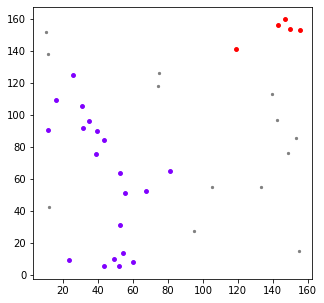

Erythroid


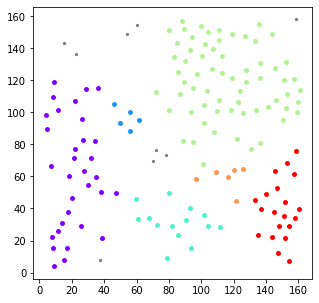

SEC


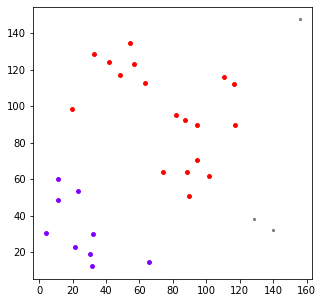

Erythroidpro


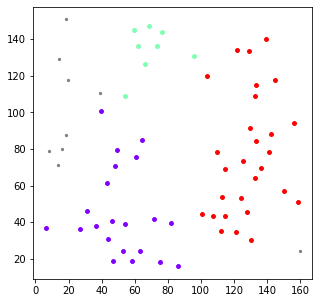

In [11]:
#visualization of DBSCAN clustering result
#legend: each dot is a cell, cells of the same color are from the same cluster, cells in the grey color are the noise identified by DBSCAN
#for fov in set(meta_df['fov']):
for fov in [9]:
    print(fov)
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']
    
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_type_l = list(set(cluster_df['cell_type']))
    for ct in cell_type_l:
        print(ct)
        plt.figure(figsize=(5,5))
        #plot all ct cells
        meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
        X_sel = np.array(meta_df_sel[['x_positions','y_positions']])
        plt.scatter(X_sel[:,0],X_sel[:,1],c = 'grey',s = 5)
        
        #higlight clusters for ct cells
        tmp_ct = cluster_df[cluster_df['cell_type']==ct]
        colors = cm.rainbow(np.linspace(0, 1, tmp_ct.shape[0]))

        for n,line in enumerate(tmp_ct['cell_idx']):
            X = np.array(meta_df_fov.loc[line][['x_positions','y_positions']])
            plt.scatter(X[:,0],X[:,1],color =colors[n],s = 15)
        plt.savefig(datap+'example/output/Figs/'+group+'_fov_'+str(fov)+"_"+ct+".cluster.pdf", dpi=100, tansparent=True)
        plt.show()

### Optimal transport between cell clusters

In [50]:
#ot 
#gene expression normalization factor
exp_df_all = pd.read_csv(datap+'example/wt_mut_exp_matrix.txt',sep='\t',index_col=None)
exp_df_norm = exp_df_all.iloc[:,2:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.99,axis = 0) 

for fov in set(meta_df['fov']):
#for fov in [9]:
    print(fov)
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']
    
    #coordinates
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_id_all = np.array(range(meta_df_fov.shape[0]))
    coord = np.array(meta_df_fov[['x_positions','y_positions']])
    S_all_arr = distance_matrix(coord,coord)
    
    #expression
    exp_df_fov = exp_df[exp_df['fov']==fov].iloc[:,2:]
    exp_df_fov = exp_df_fov/df_quantile
    exp_df_fov[exp_df_fov>1]=1
    exp_df_fov.index = cell_id_all

    #select potentially communicating cell cluster pairs (spatially adjacent)
    S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)

    #optimal transport between source and target cells
    ga_df_final = scotia.source_target_ot(S_all_arr_new, exp_df_fov, meta_df_fov, known_lr_pairs)
    if ga_df_final.shape[0]>0:
        ga_df_final.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
        ga_df_final.to_csv(datap+'example/output/ot/'+group+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")

        #post-processing of ot results by calculating averaged likelihoods
        ga_df_final['cell_pairs'] = ga_df_final['source_cell_type']+"_"+ga_df_final['target_cell_type']
        final_summary = scotia.post_ot(ga_df_final,label=group)
        final_summary.to_csv(datap+'example/output/ot/summary/'+group+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")
    

0
1
2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20


### Wilcoxon tests of LR pairs

[Text(0, 0, 'Dll1_Notch4'),
 Text(1, 0, 'Dll1_Notch2'),
 Text(2, 0, 'Kitl_Kit'),
 Text(3, 0, 'Jag2_Notch4'),
 Text(4, 0, 'Jag2_Notch2'),
 Text(5, 0, 'Dll4_Notch2'),
 Text(6, 0, 'Jag2_Notch1'),
 Text(7, 0, 'Efnb2_Ephb4'),
 Text(8, 0, 'Jag1_Notch2'),
 Text(9, 0, 'Dll1_Notch1'),
 Text(10, 0, 'Angpt2_Tek'),
 Text(11, 0, 'Jag1_Notch4')]

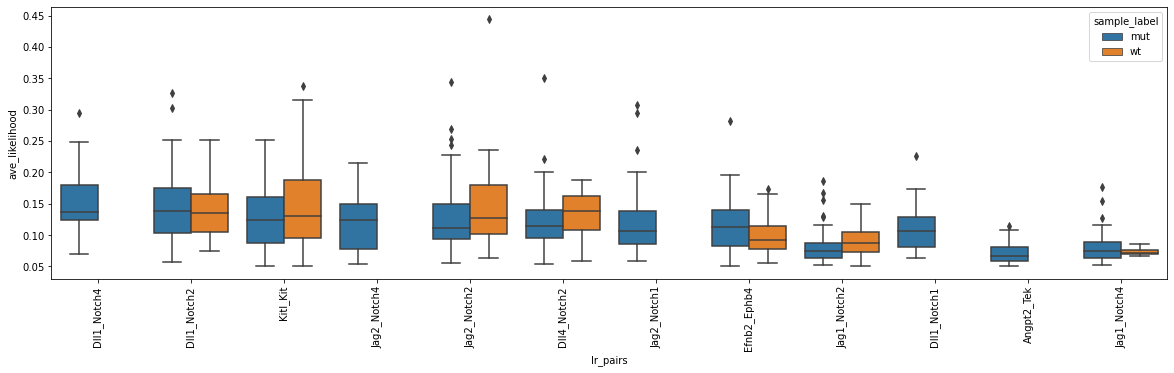

In [82]:
###summarize ot result
c_t_1 = 'Hepatocyte'
c_t_2 = 'Erythroidpro'


df_summary = pd.DataFrame([])
for label in ['wt','mut']:
    for fov in range(20):
        df_summary_tmp = read_data(datap+'example/output/ot/summary/'+label+'_fov_'+str(fov)+".ot.csv")
        if df_summary_tmp.shape[0]>0:
            df_summary = pd.concat([df_summary,df_summary_tmp])
            
df_summary = df_summary[df_summary['ave_likelihood']>0.05]
df_summary['sample_label'] = [x.split("|")[1] for x in df_summary['label']]
df_summary['lr_pairs'] = [x.split("|")[0] for x in  df_summary['label']]
df_summary['cell_pairs'] = [x.split("|")[2] for x in  df_summary['label']]
df_sel = df_summary[df_summary['cell_pairs']==c_t_1+"_"+c_t_2]
order_list = (df_sel.groupby('lr_pairs')['ave_likelihood'].median().sort_values(ascending=False)).index
df_summary_tmp = df_summary.set_index('lr_pairs')
df_summary_tmp = df_summary_tmp.loc[order_list].reset_index()
plt.figure(figsize=(20,5))
ax1 = sns.boxplot(x='lr_pairs',y='ave_likelihood',hue='sample_label',data=df_summary_tmp)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)

In [83]:
#wilcoxon_test between wt and mut
pvalue_dic = {}
statictics_dic = {}
fold_change = {}
#fold_change_mean = {}

likeli_wt = {}
likeli_mut = {}


for lr_pair in list(set(df_sel['lr_pairs'])):
#for lr_pair in ['Jag2_Notch1']:
    df_sum_fi_sel = df_sel[df_sel['lr_pairs']==lr_pair]
    
    df_ctrl =  df_sum_fi_sel[df_sum_fi_sel['sample_label']=='wt']
    df_ctrl_groupby = df_ctrl.groupby(['label'])['ave_likelihood'].mean()
    df_ctrl_size = df_ctrl.groupby(['label'])['ave_likelihood'].size()
    df_ctrl_size = np.sum([x for x in df_ctrl_size if x <2])
    
    df_mut = df_sum_fi_sel[df_sum_fi_sel['sample_label']=='mut']
    df_mut_groupby = df_mut.groupby(['label'])['ave_likelihood'].mean()
    df_mut_size = df_mut.groupby(['label'])['ave_likelihood'].size()
    df_mut_size = np.sum([x for x in df_mut_size if x <2])
    
    if len(set(df_ctrl['sample_label']))>=1 and len(set(df_mut['sample_label']))>=1 and df_ctrl_size<=1 and df_mut_size<=1:
        
        likeli_mut[lr_pair] = np.mean(df_mut['ave_likelihood'])
        likeli_wt[lr_pair] = np.mean(df_ctrl['ave_likelihood'])
    
        log_fc = np.log10(np.mean(df_mut['ave_likelihood'])/np.mean(df_ctrl['ave_likelihood']))
        fold_change[lr_pair] = log_fc
        pvalue_dic[lr_pair] = ranksums(df_mut['ave_likelihood'],df_ctrl['ave_likelihood'])[1]

p_l = [x if np.isnan(x)==False else 1.0 for x in pvalue_dic.values()]
pvalue_adj = multipletests(p_l, alpha=0.05, method='fdr_bh')[1]

In [84]:
df_summary = pd.DataFrame({'lr_pairs': fold_change.keys(),'lr_likellihood_mut_mean':likeli_mut.values(),\
                           'lr_likellihood_wt_mean':likeli_wt.values(),\
                           'log10_fc':fold_change.values(), 'Wilcoxon': pvalue_dic.values(), 'Wilcoxon_adj_pvalue': pvalue_adj})
df_summary

,lr_pairs,lr_likellihood_mut_mean,lr_likellihood_wt_mean,log10_fc,Wilcoxon,Wilcoxon_adj_pvalue
0,Dll4_Notch2,0.095345,0.150752,-0.198962,0.317311,0.528851
1,Kitl_Kit,0.160529,0.176196,-0.040445,0.741634,0.827259
2,Efnb2_Ephb4,0.134974,0.099870,0.130813,0.220671,0.528851
3,Dll1_Notch2,0.181629,0.181650,-0.000051,0.827259,0.827259
4,Jag1_Notch2,0.095150,0.126022,-0.122040,0.112351,0.528851


### Permutation tests of LR pairs

In [106]:
#permutation test 
it_n = 20
#for fov in range(it_n):
for fov in [9]:
    print(fov)
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'example/output/clustering/'+group+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']
    
    #coordinates
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_id_all = np.array(range(meta_df_fov.shape[0]))
    coord = np.array(meta_df_fov[['x_positions','y_positions']])
    S_all_arr = distance_matrix(coord,coord)
    
    #expression
    exp_df_fov = exp_df[exp_df['fov']==fov].iloc[:,2:]
    exp_df_fov = exp_df_fov/df_quantile
    exp_df_fov[exp_df_fov>1] = 1
    exp_df_fov.index = cell_id_all

    #get permutated positions and expression
    random_pos, shuffled_exp = scotia.permutation_test(coord,int(it_n))

    #select potentially communicating cell cluster pairs (spatially adjacent)
    S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)
    
    final_summary = pd.DataFrame([])
    for i_n in range(int(it_n)):
        exp_df_permu = exp_df_fov.loc[list(shuffled_exp.iloc[:,i_n])]
        coord_permu = np.array(random_pos.iloc[:,i_n*2:i_n*2+2])
        S_all_arr_permu = distance_matrix(coord_permu,coord_permu)
        mask = np.where(S_all_arr_new==np.inf)
        S_all_arr_permu[mask] = np.inf
        S_all_arr_permu = S_all_arr_permu
        
        #optimal transport
        ga_df_permu = scotia.source_target_ot(S_all_arr_permu, exp_df_permu, meta_df_fov, known_lr_pairs)
        
        if ga_df_permu.shape[0]>0:
            ga_df_permu.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
            ga_df_permu.to_csv(datap+'example/output/permutation/'+group+'_fov_'+str(fov)+".permu."+str(i_n)+".csv",header = True, index = False, sep = "\t")


            #post-processing ot results by calculating averaged likelihoods
            ga_df_permu['cell_pairs'] = ga_df_permu['source_cell_type']+"_"+ga_df_permu['target_cell_type']
            final_summary_tmp = scotia.post_ot(ga_df_permu, label=group, it_n_label = i_n)
            final_summary = pd.concat([final_summary,final_summary_tmp])
    
    final_summary.to_csv(datap+'example/output/permutation/summary/'+group+'_fov_'+str(fov)+".permu.csv",header = True, index = False, sep = "\t")

In [107]:
###########summary for permutation test
it_n = 20
#group = 'wt'
group = 'mut'
c_t_1 = 'Hepatocyte'
c_t_2 = 'Erythroidpro'


df_ot = pd.DataFrame([])
df_permu = pd.DataFrame([])

compare_dic ={}
for fov in range(it_n):
    
    #import ot result
    df_ot_tmp = read_data(datap+'example/output/ot/summary/'+label+'_fov_'+str(fov)+".ot.csv")
    if df_summary_tmp.shape[0]>0:
        df_ot = pd.concat([df_ot,df_ot_tmp])
    
    #import permutation result
    df_permu_tmp = read_data(datap+'example/output/permutation/summary/'+group+'_fov_'+str(fov)+".permu.csv")
    if df_permu_tmp.shape[0]>0:
        df_permu = pd.concat([df_permu,df_permu_tmp])
        
df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]  

df_permu['it_n'] = [x.split('|')[-1] for x in df_permu['label']]
df_permu['lr_pairs'] = [x.split('|')[0] for x in df_permu['label']]
df_permu['label_new'] = df_permu['lr_pairs']+"|"+df_permu['it_n'].map(str)
df_permu['cell_pairs'] = [x.split('|')[2] for x in df_permu['label']]


c_t_p = c_t_1+"_"+c_t_2
df_ot_tmp = df_ot[df_ot['cell_pairs'] == c_t_p]
df_permu_tmp = df_permu[df_permu['cell_pairs'] == c_t_p]

if df_permu_tmp.shape[0]>0:
    df_ot_groupby = df_ot_tmp.groupby(['label'])['ave_likelihood'].sum().to_frame().reset_index()
    df_ot_groupby.index = [x.split('|')[0] for x in df_ot_groupby['label']]
    df_permu_groupby = df_permu_tmp.groupby(['label_new'])['ave_likelihood'].sum()

    for i in df_ot_groupby.index:
        compare_dic[i+"|"+group+"|"+c_t_p] = 0
        df_permu_groupby_sel = df_permu_groupby[df_permu_groupby.index.str.contains(i+"\|")]
        for j in df_permu_groupby_sel:
            if j > df_ot_groupby.loc[i,'ave_likelihood']:
                compare_dic[i+"|"+group+"|"+c_t_p] += 1/it_n
                        
p_l = [round(x,3) for x in compare_dic.values()]
pvalue_adj = multipletests(p_l, alpha=0.05, method='fdr_bh')[1]
pvalue_adj = [round(x,3) for x in pvalue_adj]

In [108]:
compare_dic

{'Angpt2_Tek|mut|Hepatocyte_Erythroidpro': 0.9500000000000003,
 'Dll1_Notch1|mut|Hepatocyte_Erythroidpro': 0.15000000000000002,
 'Dll1_Notch2|mut|Hepatocyte_Erythroidpro': 0,
 'Dll1_Notch4|mut|Hepatocyte_Erythroidpro': 0,
 'Dll4_Notch2|mut|Hepatocyte_Erythroidpro': 0.3,
 'Efnb2_Ephb4|mut|Hepatocyte_Erythroidpro': 0.7500000000000001,
 'Jag1_Notch2|mut|Hepatocyte_Erythroidpro': 0,
 'Jag1_Notch4|mut|Hepatocyte_Erythroidpro': 0.35,
 'Jag2_Notch1|mut|Hepatocyte_Erythroidpro': 0.44999999999999996,
 'Jag2_Notch2|mut|Hepatocyte_Erythroidpro': 0,
 'Jag2_Notch4|mut|Hepatocyte_Erythroidpro': 0.35,
 'Kitl_Kit|mut|Hepatocyte_Erythroidpro': 0}

### Visualization of LR pairs in FOVs

0


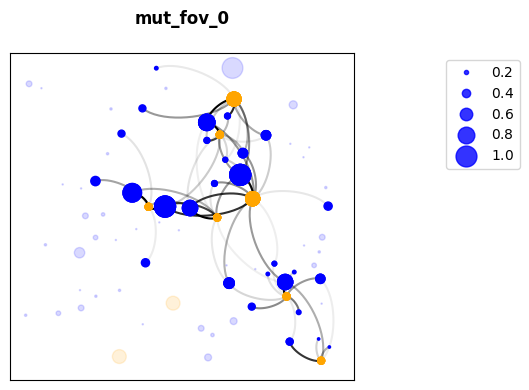

In [13]:
#visualization of LR paris in FOVs
#Dots represent ligand gene expression in source cells (orange) or receptor gene expression in target cells (blue) with the size indicating normalized expression
#levels and the locations indicating spatial coordinates of cell centroids. Cells expressing ligands or receptors but not
#participating in interactions are shown as semi-transparent dots

group = 'mut'

source_ct = 'Hepatocyte'
target_ct = 'Erythroidpro'

l_gene = 'Kitl'
r_gene = 'Kit'

#for fov in set(meta_df['fov']):
for fov in [0]:
    meta_df_fov = meta_df[meta_df['fov']==fov]
    meta_df_fov.index = range(meta_df_fov.shape[0])
    df_summary_tmp = read_data(datap+'example/output/ot/'+group+'_fov_'+str(fov)+".ot.csv")
    if df_summary_tmp.shape[0]>0:
        df_sel = df_summary_tmp[df_summary_tmp['source_cell_type']==source_ct]
        df_sel = df_sel[df_sel['target_cell_type']==target_ct]
        df_sel = df_sel[df_sel['ligand_recptor']==l_gene+'_'+r_gene]
        if df_sel.shape[0]>=5:
            print(fov)
            exp_df_fov = exp_df[exp_df['fov']==fov].iloc[:,2:]
            exp_df_fov = exp_df_fov/df_quantile
            exp_df_fov[exp_df_fov>1]=1
            exp_df_fov.index = range(meta_df_fov.shape[0])

            #idx
            l_id_sel = df_sel['source_cell_idx']
            r_id_sel = df_sel['receptor_cell_idx']
            #exp
            l_exp_sel = exp_df_fov.loc[l_id_sel][l_gene]
            r_exp_sel = exp_df_fov.loc[r_id_sel][r_gene]
            #coordinates
            l_pos = np.array(meta_df_fov.loc[l_id_sel][['x_positions','y_positions']])
            r_pos = np.array(meta_df_fov.loc[r_id_sel][['x_positions','y_positions']])



            l_id_all = meta_df_fov[meta_df_fov['annotation']==source_ct].index
            r_id_all = meta_df_fov[meta_df_fov['annotation']==target_ct].index
            l_exp_all = exp_df_fov.loc[l_id_all][l_gene]
            r_exp_all = exp_df_fov.loc[r_id_all][r_gene]
            l_uniq_pos = meta_df_fov.loc[l_id_all][['x_positions','y_positions']].values
            r_uniq_pos = meta_df_fov.loc[r_id_all][['x_positions','y_positions']].values


            plt.figure(figsize=(6,4))
            ax1 = plt.scatter(l_pos[:,0],l_pos[:,1],c = 'orange',s = (15*l_exp_sel)**2,label = l_gene,alpha = 1,zorder=2)
            ax2 = plt.scatter(r_pos[:,0],r_pos[:,1],c = 'blue',s = (15*r_exp_sel)**2,label = r_gene,alpha = 1,zorder=3)
            ax3 = plt.scatter(l_uniq_pos[:,0],l_uniq_pos[:,1],c = 'orange',s = (15*l_exp_all)**2,alpha = 0.15)
            ax4 = plt.scatter(r_uniq_pos[:,0],r_uniq_pos[:,1],c = 'blue',s = (15*r_exp_all)**2,alpha = 0.15)

            G = list(df_sel['likelihood'])
            ax = plt.gca()
            all_curves = scotia.curved_edges(l_pos,r_pos)
            for n,i in enumerate(list(range(l_pos.shape[0]))):
                lc = LineCollection([all_curves[i]], colors='black',alpha = np.min([G[n]/np.quantile(G,q=0.9),1]), zorder=0)
                ax.add_collection(lc)



            plt.title(group+"_fov_"+str(fov)+"\n",fontweight="bold")
            plt.tick_params(
                axis='both',         
                which='both',
                bottom=False,    
                left=False,  
                labelleft=False,
                labelbottom=False)
            kw = dict(prop="sizes", num=5,func=lambda s: np.sqrt(s)/15,color ='blue',alpha=0.8)
            plt.legend(*ax2.legend_elements(**kw),bbox_to_anchor=(1.5,1))
            plt.tight_layout()
            
            #plt.savefig(datap+'/example/output/Figs/'+group+"_fov_"+str(fov)+'_'+source_ct+"_"+target_ct+'.spatail.pdf',dpi=100)
            plt.show()